In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [2]:
import sys   
print(sys.version) 

3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2356341388873721536
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8321866648601543111
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1408043827
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8733290746702041782
physical_device_desc: "device: 0, name: GeForce MX250, pci bus id: 0000:06:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9106748898944419063
physical_device_desc: "device: XLA_GPU device"
]
2.3.0


In [4]:
data_dir = r"C:\Users\Harry2002\Desktop\Imagetest"
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

14548


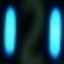

In [7]:

arrmor1 = list(data_dir.glob('1/*'))
arrmor2 = list(data_dir.glob('2/*'))
arrmor3 = list(data_dir.glob('3/*'))


PIL.Image.open(str(arrmor2[2]))

In [8]:
batch_size = 32
img_height = 64
img_width = 64

# 数据集划分

## 训练集

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 7274 files belonging to 3 classes.
Using 5820 files for training.
(32, 64, 64, 3)
(32,)


## 测试集

In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7274 files belonging to 3 classes.
Using 1454 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['1', '2', '3']


# 数据增强

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def prepare(ds, shuffle=False, augment=False):
  for image_batch, labels_batch in ds:
      print(image_batch.shape)
      print(labels_batch.shape)
      break
  
  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
train_ds = prepare(train_ds, shuffle=True, augment=True)

(32, 64, 64, 3)
(32,)


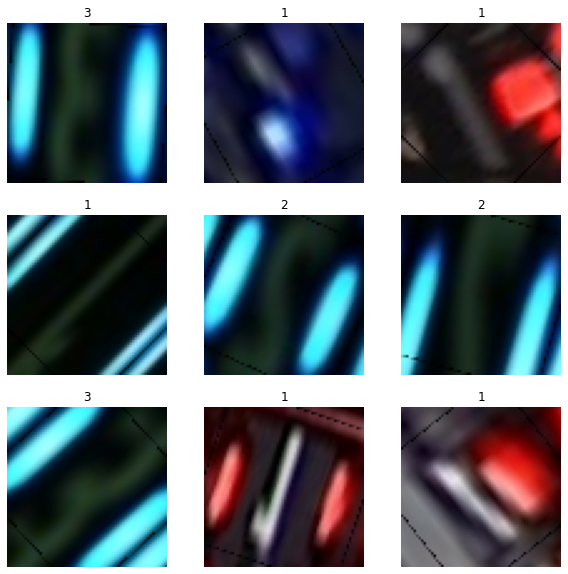

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 数据标准化

In [18]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)# [0,255]缩小到[0,1]

In [19]:
# map接收一个函数，Dataset中的每个元素都会被当作这个函数的输入，并将函数返回值作为新的Dataset
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))  # x为图像，y为标签
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [20]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),

  ]
)

# 模型搭建

In [21]:
num_classes = 3

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)       

# 模型训练

In [24]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
182/182 [==============================] - 8s 42ms/step - loss: 0.3403 - accuracy: 0.8689 - val_loss: 0.1530 - val_accuracy: 0.9223
Epoch 2/50
182/182 [==============================] - 5s 25ms/step - loss: 0.1376 - accuracy: 0.9502 - val_loss: 0.0569 - val_accuracy: 0.9780
Epoch 3/50
182/182 [==============================] - 4s 22ms/step - loss: 0.0448 - accuracy: 0.9864 - val_loss: 0.0098 - val_accuracy: 0.9959
Epoch 4/50
182/182 [==============================] - 4s 21ms/step - loss: 0.0452 - accuracy: 0.9863 - val_loss: 0.0100 - val_accuracy: 0.9966
Epoch 5/50
182/182 [==============================] - 4s 22ms/step - loss: 0.0209 - accuracy: 0.9948 - val_loss: 0.0143 - val_accuracy: 0.9959 0s - loss: 0.0191 - accuracy
Epoch 6/50
182/182 [==============================] - 4s 23ms/step - loss: 0.0228 - accuracy: 0.9936 - val_loss: 0.0102 - val_accuracy: 0.99720.0231 - accuracy
Epoch 7/50
182/182 [==============================] - 4s 22ms/step - loss: 0.0210 - accuracy: 0.

# 模型保存

In [26]:
model.save(r'C:\Users\Harry2002\Desktop\tf_test\saved_model\my_model4')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Harry2002\Desktop\tf_test\saved_model\my_model4\assets


# 图像数字识别

In [31]:
image_raw_png = tf.compat.v1.gfile.FastGFile(r'C:\Users\Harry2002\Desktop\tf_data\3\trainingImg3\126.jpg', 'rb').read()
img_array = tf.image.decode_jpeg(image_raw_png)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Instructions for updating:
Use tf.gfile.GFile.


ValueError: in user code:

    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Program Files\Python38\Lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 512 but received input with shape [None, 2048]


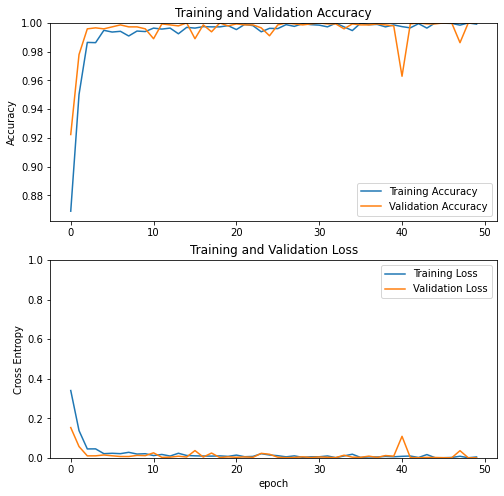

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()